In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("drive/MyDrive")
image_path = Path("inaturalist/")

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(data_path / "data.zip", "r") as zip_ref:
    print("unzipping data")
    zip_ref.extractall(image_path)

Did not find inaturalist directory, creating one...
unzipping data


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
!pip install torchinfo
from torchinfo import summary

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda


In [ ]:
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms=weights.transforms()

In [ ]:
from drive.MyDrive.helpers.data_setup import create_dataloaders
train_dataloader, test_dataloader, class_names=create_dataloaders(train_dir='inaturalist/data/train/',test_dir='inaturalist/data/test/',transform=auto_transforms,batch_size=64,num_workers=os.cpu_count(),)

In [ ]:
class_names[41]

'oriental_rat_snake'

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model_0=efficientnet_b0(weights="DEFAULT")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 171MB/s]


In [ ]:
summary(model=model_0, input_size=(32,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
#for param in model_0.features.parameters():
#    param.requires_grad = False
next(iter(model_0.features.parameters())).is_cuda

True

In [ ]:
summary(model=model_0, input_size=(32,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
output_shape=len(class_names)
model_0.classifier=torch.nn.Sequential(
    torch.nn.Dropout(p=0.2,inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

In [ ]:
summary(model=model_0, input_size=(32,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 55]             --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.0001)

In [ ]:
next(iter(model_0.features.parameters())).is_cuda

True

In [ ]:
import drive.MyDrive.helpers.engine as engine
import drive.MyDrive.helpers.utils as utils
results=engine.train(model=model_0,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=10,
                     device=device)
utils.save_model(model_0,'trained_model','/content/drive/MyDrive/model_2.pth')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5777 | train_acc: 0.6004 | test_loss: 0.9922 | test_acc: 0.7006
Epoch: 2 | train_loss: 0.7625 | train_acc: 0.7768 | test_loss: 0.8017 | test_acc: 0.7493
Epoch: 3 | train_loss: 0.5369 | train_acc: 0.8413 | test_loss: 0.7840 | test_acc: 0.7565
Epoch: 4 | train_loss: 0.3959 | train_acc: 0.8825 | test_loss: 0.7772 | test_acc: 0.7685
Epoch: 5 | train_loss: 0.2974 | train_acc: 0.9106 | test_loss: 0.7962 | test_acc: 0.7714
Epoch: 6 | train_loss: 0.2285 | train_acc: 0.9318 | test_loss: 0.8151 | test_acc: 0.7758
Epoch: 7 | train_loss: 0.1784 | train_acc: 0.9457 | test_loss: 0.8397 | test_acc: 0.7740
Epoch: 8 | train_loss: 0.1412 | train_acc: 0.9592 | test_loss: 0.8893 | test_acc: 0.7809
Epoch: 9 | train_loss: 0.1124 | train_acc: 0.9670 | test_loss: 0.9331 | test_acc: 0.7853
Epoch: 10 | train_loss: 0.1002 | train_acc: 0.9699 | test_loss: 0.9357 | test_acc: 0.7843
[INFO] Saving model to: /content/drive/MyDrive/model_2.pth


In [ ]:
print(results)

{'train_loss': [1.5776560394050076, 0.7625163677906575, 0.536911986941515, 0.39592181494849366, 0.2974260183224498, 0.2284799246550646, 0.17838481813669205, 0.1411569658504409, 0.11240788497339371, 0.10021152441812203], 'train_acc': [0.6004237178156145, 0.776844113372093, 0.8413426598837209, 0.8824653498754153, 0.9105845099667774, 0.9318028446843853, 0.9456628945182725, 0.9591822830149501, 0.966975316652824, 0.9698628270348837], 'test_loss': [0.9922088155912798, 0.8017116057318311, 0.7839921165344327, 0.7771565196819084, 0.7962272818698439, 0.8151392669871796, 0.8397131212228952, 0.8893432142429574, 0.9330777065005413, 0.935736361457858], 'test_acc': [0.7005931170292573, 0.7492732558139535, 0.7564938109527383, 0.7685436984246061, 0.771427231807952, 0.7758345836459114, 0.7740177231807952, 0.780921792948237, 0.7853174231057763, 0.784250750187547]}


In [ ]:
len(results)

4

In [ ]:
results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
import matplotlib.pyplot as plt

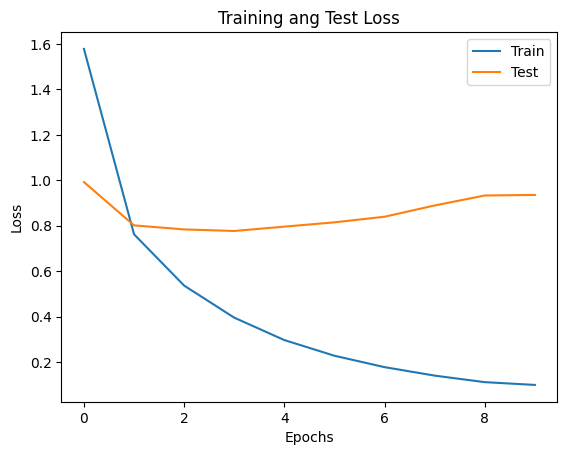

In [ ]:
# For plotting train and test loss
fig,ax=plt.subplots()
ax.set_title('Training ang Test Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.plot(range(len(results['train_loss'])),results['train_loss'],label='Train')
plt.plot(range(len(results['test_loss'])),results['test_loss'],label='Test')
ax.legend()

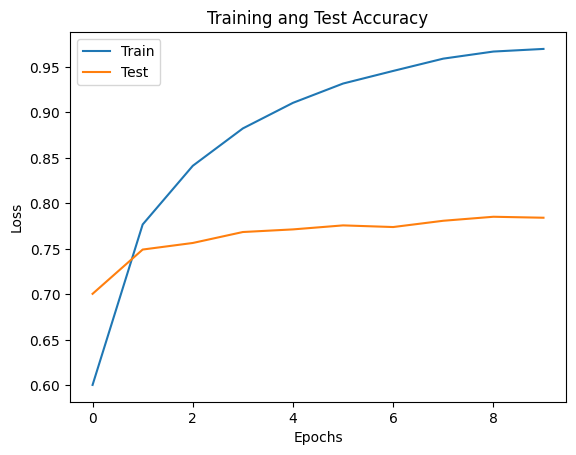

In [ ]:
# For plotting train and test accuracy
fig,ax=plt.subplots()
ax.set_title('Training ang Test Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.plot(range(len(results['train_acc'])),results['train_acc'],label='Train')
plt.plot(range(len(results['test_acc'])),results['test_acc'],label='Test')
ax.legend()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from typing import List, Tuple
def test(model: torch.nn.Module, dataloader,loss_fn: torch.nn.Module, device:torch.device)->Tuple[List[int],List[int]]:
  model.eval()

  y_test, y_pred = [],[]
  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X,y = X.to(device),y.to(device)
      test_pred_logits = model(X)
      y_pred.append(test_pred_logits.tolist())
      y_test.append(y.tolist())
  return y_test, y_pred
y_test,y_pred=test(model=model_0,dataloader=test_dataloader,loss_fn=loss_fn,device=device)
print(len(y_test),len(y_pred))

86 86


In [ ]:
def flatten(list_of_list):
  return [item for row in list_of_list for item in row]